# Code for Graph Differential Equations

This notebook contains code for a implementation of the GDE paper based on pytorch geometric and torchdiffeq.

In [1]:
import torch
from torch_geometric.loader import DataLoader
from data_creation import create_dataset, to_pyg_data_true
from torch_geometric.nn import GCNConv
from torchdiffeq import odeint

c:\Users\Lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generate data of 1000 graphs (input,output pairs) for training the GDE on, along with 128 graphs for testing the method

In [2]:
# run only if new data is desired

# set ODE dimension and amount of data points (n_data, x(0) to x(T)) desired
ode_dim = 3
n_data = 10

# create dataset based on specified parameters
x_exact, x_train, y_train, param = create_dataset(ode_dim,n_data,1000)

# create pytorch_geometric-compatible dataset for training
dataset_train = []
for i in range(0,len(x_train)):
    p = param[i]
    param_tensor = torch.cat((p.Win.flatten(),p.Wout.flatten(),p.bin.flatten(),p.bout.flatten(),p.gamma.flatten()))
    dataset_train.append(to_pyg_data_true(x_train[i],y_train[i],ode_dim,n_data))

loader = DataLoader(dataset_train,batch_size=32,shuffle=True)

# create dataset for testing based on specified parameters
x_text_exact, x_test, y_test, param_test = create_dataset(ode_dim,n_data,128)

# create pytorch_geometric-compatible dataset for testing
dataset = []
for i in range(0,len(x_test)):
    p = param_test[i]
    param_tensor = torch.cat((p.Win.flatten(),p.Wout.flatten(),p.bin.flatten(),p.bout.flatten(),p.gamma.flatten()))
    dataset.append(to_pyg_data_true(x_test[i],y_test[i],ode_dim,n_data))

test_loader = DataLoader(dataset,batch_size=128,shuffle=True)

We define a GCDE (Graph Convolution Differential Equation) as defined in Graph Neural Ordinary Differential Equations, Poli et al. 2021

In [3]:
# define GCN with two layers as nODE function (rhs of ODE)
class GCDE_F(torch.nn.Module):

    def __init__(self, dim, out_dim = None, hidden_channels = 16):
        super(GCDE_F, self).__init__()

        # if out_dim is not specified, set it to dim (to have ODE mapping to same space)
        if out_dim is None:
            out_dim = dim
        
        # define two Graph Convolutional layers
        self.gcn1 = GCNConv(dim, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, out_dim)

    def forward(self, t, x, edge_index):

        # define forward pass through GCN layers
        x = self.gcn1(x, edge_index=edge_index)
        x = torch.nn.functional.leaky_relu(x)
        return self.gcn2(x,edge_index=edge_index)

# define GCDE model based using GCDE_F as right-hand side of ODE along with linear input and output projections
class GCDE(torch.nn.Module):

    def __init__(self, input_dim, output_dim, ode_dim = None, integration_time = torch.tensor([0,1], dtype=torch.float)):
        super(GCDE, self).__init__()

        if ode_dim is None:
            ode_dim = input_dim

        # set integration time for ODE solver
        self.integration_time = integration_time

        # define Linear layer to process input, then go through ODE layer and finally go through another linear layer to get to correct output dimension
        self.lin1 = torch.nn.Linear(input_dim, ode_dim)
        self.dropout = torch.nn.Dropout(p=0.3)
        self.ode_f = GCDE_F(ode_dim)
        self.lin2 = torch.nn.Linear(ode_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # pass through first linear layer
        x = self.lin1(x)
        x = torch.nn.functional.leaky_relu(x)

        x = self.dropout(x)

        # define the ODE function based on edge_index
        def ode_func(t, x):
            return self.ode_f(t, x, edge_index)

        # pass through ODE integration
        x = odeint(ode_func, x, self.integration_time)[-1]

        # pass through second linear layer and return
        return self.lin2(x)
        

In [4]:
# Ensure input_dim and output_dim are set correctly
input_dim = 2*n_data

# output ode_dim features per node, indicating different connections in adjacency matrix
output_dim = ode_dim

model = GCDE(input_dim, output_dim, 5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

criterion = torch.nn.MSELoss()

train_loss = []

for epoch in range(100):
    model.train()

    tr_loss = 0
    full_loss = 0
    for data in loader:
        data = data.to(device)

        batch_size = data.batch.max().item()+1

        optimizer.zero_grad()

        out = model(data)

        adj = out.flatten()

        binary_vec = torch.zeros(len(data.y)).to(device)
        for elem in range(len(data.y)):
            if data.y[elem] > 1e-4:
                binary_vec[elem] = 1
            if data.y[elem] < -1e4:
                binary_vec[elem] = -1

        loss = criterion(adj,binary_vec)

        train_loss.append(loss)
        full_loss += loss

        loss.backward()
        optimizer.step()
        
        tr_loss += loss
        
    #train_loss.append(full_loss)
    print(full_loss.item())

for data in dataset_train:
    z = model.encode(data.to(device), data.edge_index)

    recon = model.decode(z,data.edge_index)

    print(recon)

c:\Users\Lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\torchdiffeq\_impl\misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


KeyboardInterrupt: 

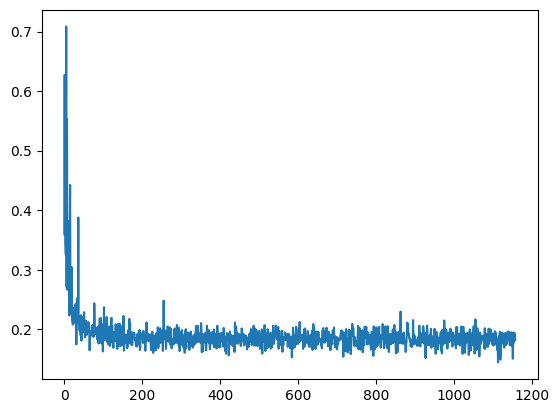

In [143]:
import matplotlib.pyplot as plt

tr_l = [train_loss[i].to('cpu').detach().numpy() for i in range(0,len(train_loss))]
plt.plot(range(0,len(tr_l)),tr_l)
plt.show()

In [146]:
def get_adjacency(W):
        values_log_W = torch.sort(torch.log(torch.abs(W.flatten())))[0]
        treshold = values_log_W[torch.sort(values_log_W[1:] - values_log_W[:-1])[1][-1] + 1]
        W_bool_activation = (W >= torch.exp(treshold)).double()
        W_bool_repr = (W <= -torch.exp(treshold)).double()
        A = W_bool_activation-W_bool_repr
        return A

x_val_exact, x_val, y_val, param_val = create_dataset(ode_dim,n_data,100)

val_dataset = []
param_list = []

for i in range(0,len(x_val)):
    p = param_val[i]
    param_vec = torch.cat((p.Win.flatten(), p.Wout.flatten(), p.bin, p.bout, p.gamma)).numpy()
    param_list.append(param_vec)
    val_dataset.append(to_pyg_data_true(x_val[i],y_val[i],ode_dim,n_data))

val_loader = DataLoader(val_dataset,batch_size=100)

correct = 0
init_correct = 0
total = 0
elem_wise = 0
elem_wise_init = 0
elems_total = 0

changed = 0
fixed = 0
destroyed = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
k = 0
for batch in val_loader:
    batch = batch.to(device)
    out = model(batch)

    Ahat = out.flatten()

    # Ahat = get_adjacency(model(batch)).t()[0]
    A = get_adjacency(batch.y)
    Ahat = get_adjacency(Ahat)

    for i in range(0,len(A)):

        if abs(Ahat[i]-A[i]) < 0.001:
             elem_wise += 1   
            
        elems_total += 1

print(elem_wise/elems_total)

0.2511111111111111
